# Hybrid Neural Networks Lab using PyTorch
 
This notebook implements three models:
 
1. **MLP Model**: A standard multilayer perceptron with two hidden layers.
2. **RBF Model**: A network using a custom Radial Basis Function (RBF) layer.
3. **Hybrid Model**: A model that takes the penultimate output of a pretrained MLP, feeds it into an RBF layer, then into a final classification layer.

Two datasets are used for experimentation: the Iris dataset and Fashion MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

# For data loading
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

# Custom RBF Layer

The `RBFLayer` computes Gaussian activations for each unit based on trainable centers and beta (width) parameters.

The output for an input vector $x$ is computed as:

$$
\text{output}_i = \exp\Big(-\beta_i \cdot \|x - c_i\|^2\Big)
$$

where $c_i$ is the trainable center for the $i$-th unit and $\beta_i$ is the trainable width.

In [2]:
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, gamma=1.0):
        """
        Args:
            in_features (int): Dimensionality of the input.
            out_features (int): Number of RBF units.
            gamma (float): Initial value for beta parameters.
        """
        super(RBFLayer, self).__init__()
        self.out_features = out_features
        # Initialize centers randomly.
        self.centers = nn.Parameter(torch.randn(out_features, in_features))
        # Initialize betas with the constant gamma.
        self.betas = nn.Parameter(torch.full((out_features,), gamma))
    
    def forward(self, x):
        # x: (batch_size, in_features)
        # Expand dimensions to compute the Euclidean distance between x and each center.
        # x_expanded: (batch, 1, in_features)
        # centers_expanded: (1, out_features, in_features)
        x_expanded = x.unsqueeze(1)
        centers_expanded = self.centers.unsqueeze(0)
        diff = x_expanded - centers_expanded  # (batch, out_features, in_features)
        l2 = torch.sum(diff ** 2, dim=2)  # (batch, out_features)
        # Compute Gaussian RBF activation: exp(-beta * ||x - center||^2)
        return torch.exp(-self.betas * l2)

## Model Definitions

We define three models:

1. **MLP:** Two hidden layers with a selectable activation function.
2. **RBFNetwork:** Uses the custom RBF layer followed by a linear classification layer.
3. **HybridNetwork:** Uses a pretrained MLP’s penultimate layer output as input to an RBF layer and then a classification layer. We use a skip connection between the MLP layer and the classification layer, otherwise the model doesn't learn at all. 

In [3]:
# Custom activation functions
class Sinusoid(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class StepFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-Through Estimator: simply pass the gradient through.
        input, = ctx.saved_tensors
        return grad_output

class StepActivation(nn.Module):
    def forward(self, x):
        return StepFunction.apply(x)

# MLP model with multiple activation functions support
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, num_classes=3, activation='relu'):
        """
        Args:
            input_dim (int): Input feature dimension.
            hidden1 (int): Number of units in the first hidden layer.
            hidden2 (int): Number of units in the second (penultimate) hidden layer.
            num_classes (int): Number of output classes.
            activation (str): Activation function to use. Supported values are:
                              'relu', 'tanh', 'sigmoid' (or 'logistic'),
                              'identity', 'softplus', 'elu', 'prelu', 'sinusoid', 'step'.
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, num_classes)
        
        act = activation.lower()
        if act == 'relu':
            self.activation = nn.ReLU()
        elif act == 'tanh':
            self.activation = nn.Tanh()
        elif act in ['sigmoid', 'logistic']:
            self.activation = nn.Sigmoid()
        elif act == 'identity':
            self.activation = nn.Identity()
        elif act == 'softplus':
            self.activation = nn.Softplus()
        elif act == 'elu':
            self.activation = nn.ELU()
        elif act == 'prelu':
            self.activation = nn.PReLU()
        elif act == 'sinusoid':
            self.activation = Sinusoid()
        elif act == 'step':
            self.activation = StepActivation()
        else:
            raise ValueError("Unsupported activation function: " + activation)

    def forward(self, x, return_hidden=False):
        a1 = self.activation(self.fc1(x))
        a2 = self.activation(self.fc2(a1))
        out = self.out(a2)
        if return_hidden:
            return a2, out
        return out

In [4]:
class RBFNetwork(nn.Module):
    def __init__(self, input_dim, rbf_units=32, num_classes=3, gamma=1.0):
        """
        RBF network using the custom RBFLayer.
        """
        super(RBFNetwork, self).__init__()
        self.rbf = RBFLayer(input_dim, rbf_units, gamma=gamma)
        self.fc = nn.Linear(rbf_units, num_classes)
    
    def forward(self, x):
        x = self.rbf(x)
        x = self.fc(x)
        return x

In [5]:
# HybridNetwork Definition
class HybridNetwork(nn.Module):
    def __init__(self, mlp, hidden_dim, rbf_units, num_classes, gamma):
        """
        Hybrid network with a skip connection:
          - Extracts features from the MLP's penultimate layer.
          - Normalizes those features.
          - Passes the normalized features through an RBF layer.
          - Concatenates the normalized features with the RBF output.
          - Feeds the combined representation to a final linear layer.
          
        This design provides a direct gradient path from the MLP features to the output.
        """
        super(HybridNetwork, self).__init__()
        self.mlp = mlp  # MLP is trained end-to-end (not frozen)
        self.norm = nn.LayerNorm(hidden_dim)
        self.rbf = RBFLayer(hidden_dim, rbf_units, gamma=gamma)
        self.fc = nn.Linear(hidden_dim + rbf_units, num_classes)
    
    def forward(self, x):
        features, _ = self.mlp.forward(x, return_hidden=True)
        features_norm = self.norm(features)
        rbf_out = self.rbf(features_norm)
        # Concatenate along the feature dimension.
        combined = torch.cat([features_norm, rbf_out], dim=1)
        out = self.fc(combined)
        return out

## Data Loading Functions

Two functions are provided:

1. **load_iris_data:** Loads the Iris dataset, standardizes it, and creates DataLoaders.
2. **load_fashion_mnist_data:** Loads Fashion MNIST, normalizes and flattens the images, and creates DataLoaders.

In [6]:
def load_iris_data(batch_size=32):
    data = load_iris()
    X = data.data
    y = data.target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y))
    return train_loader, test_loader, input_dim, num_classes

def load_fashion_mnist_data(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize while still an image (shape: [C, H, W])
        transforms.Lambda(lambda x: x.view(-1))  # Then flatten the tensor
    ])
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    input_dim = 28 * 28  # FashionMNIST images are 28x28
    num_classes = 10
    return train_loader, test_loader, input_dim, num_classes

## Training and Evaluation Function

This function trains a model for a fixed number of epochs using the Adam optimizer and cross-entropy loss.
It then evaluates the model on the test set and prints a classification report.

In [ ]:
# Training and evaluation function
def train_model(model, train_loader, test_loader, epochs=50, lr=1e-3, device='cpu', print_every=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        if (epoch+1) % print_every == 0 or epoch == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}", flush=True)
    
    # Evaluation on test set
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}", flush=True)
    print("\nClassification Report:", flush=True)
    clf_report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    print(classification_report(all_labels, all_preds, zero_division=0), flush=True)
    
    # Return metrics as a dictionary.
    return {"test_loss": test_loss, "test_accuracy": accuracy, "classification_report": clf_report}

## Experiment Runner

This function runs experiments on a specified dataset ('iris' or 'fashion_mnist') by:

- Training an MLP model.
- Training an RBF model.
- Training a Hybrid model (using the pretrained MLP’s hidden layer).

For the hybrid model, the MLP’s parameters are frozen.

In [8]:
# %% Updated Experiment Runner for Activation Experiments
def run_activation_experiments(dataset_name, device='cpu'):
    """
    Runs experiments on the specified dataset.
    1. Trains a pure RBF model as a baseline.
    2. For each activation function:
         - Trains an MLP.
         - Trains a Hybrid model (with a skip connection) using the MLP's features.
    Returns a list of dictionaries with metrics from each run.
    """
    activation_list = ['relu', 'tanh', 'sigmoid', 'identity', 'softplus', 'elu', 'prelu', 'sinusoid', 'step']
    results = []
    
    if dataset_name == 'iris':
        train_loader, test_loader, input_dim, num_classes = load_iris_data()
        dataset_info = "Iris"
        hidden_dim = 32  # MLP's second hidden layer dimension
        rbf_units = 32
        gamma = 1.0
    elif dataset_name == 'fashion_mnist':
        train_loader, test_loader, input_dim, num_classes = load_fashion_mnist_data()
        dataset_info = "FashionMNIST"
        hidden_dim = 32
        rbf_units = 128   # More units for higher-dimensional data
        gamma = 0.01      # Lower gamma for better scaling
    else:
        raise ValueError("Unknown dataset name. Use 'iris' or 'fashion_mnist'.")
    
    print("=====================================")
    print(f"Running experiments on {dataset_info} dataset")
    print("=====================================\n")
    
    # --- Pure RBF Model Baseline ---
    print(">>> Pure RBF Model Training:")
    rbf_model = RBFNetwork(input_dim=input_dim, rbf_units=rbf_units, num_classes=num_classes, gamma=gamma)
    rbf_metrics = train_model(rbf_model, train_loader, test_loader, epochs=30, lr=1e-3, device=device, print_every=10)
    results.append({
        "dataset": dataset_info,
        "model_type": "Pure RBF",
        "activation": None,
        "test_loss": rbf_metrics["test_loss"],
        "test_accuracy": rbf_metrics["test_accuracy"]
    })
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # --- Loop over activation functions for MLP and Hybrid ---
    for activation in activation_list:
        print(f"\n--- Testing with activation function: {activation} ---\n")
        
        # Train the MLP model.
        print("MLP Model Training:")
        mlp_model = MLP(input_dim=input_dim, hidden1=64, hidden2=hidden_dim, num_classes=num_classes, activation=activation)
        mlp_metrics = train_model(mlp_model, train_loader, test_loader, epochs=30, lr=1e-3, device=device, print_every=10)
        results.append({
            "dataset": dataset_info,
            "model_type": "MLP",
            "activation": activation,
            "test_loss": mlp_metrics["test_loss"],
            "test_accuracy": mlp_metrics["test_accuracy"]
        })
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        
        # Train the Hybrid model.
        print("\nHybrid Model Training:")
        hybrid_model = HybridNetwork(mlp=mlp_model, hidden_dim=hidden_dim, rbf_units=rbf_units, num_classes=num_classes, gamma=gamma)
        hybrid_metrics = train_model(hybrid_model, train_loader, test_loader, epochs=30, lr=1e-3, device=device, print_every=10)
        results.append({
            "dataset": dataset_info,
            "model_type": "Hybrid",
            "activation": activation,
            "test_loss": hybrid_metrics["test_loss"],
            "test_accuracy": hybrid_metrics["test_accuracy"]
        })
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    return results

## Main Execution

This cell runs experiments on both the Iris and Fashion MNIST datasets. It also visualizes and saves experiment results. 

Running experiments on Iris dataset

>>> Pure RBF Model Training:
Epoch 1/30, Loss: 1.0665
Epoch 10/30, Loss: 1.0164
Epoch 20/30, Loss: 0.9548
Epoch 30/30, Loss: 0.8834
Test Loss: 0.8802, Test Accuracy: 0.6333

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.50      1.00      0.67         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.44      0.67      0.53        30
weighted avg       0.43      0.63      0.50        30


--- Testing with activation function: relu ---

MLP Model Training:
Epoch 1/30, Loss: 1.1297
Epoch 10/30, Loss: 0.7212
Epoch 20/30, Loss: 0.3849
Epoch 30/30, Loss: 0.2403
Test Loss: 0.1974, Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      

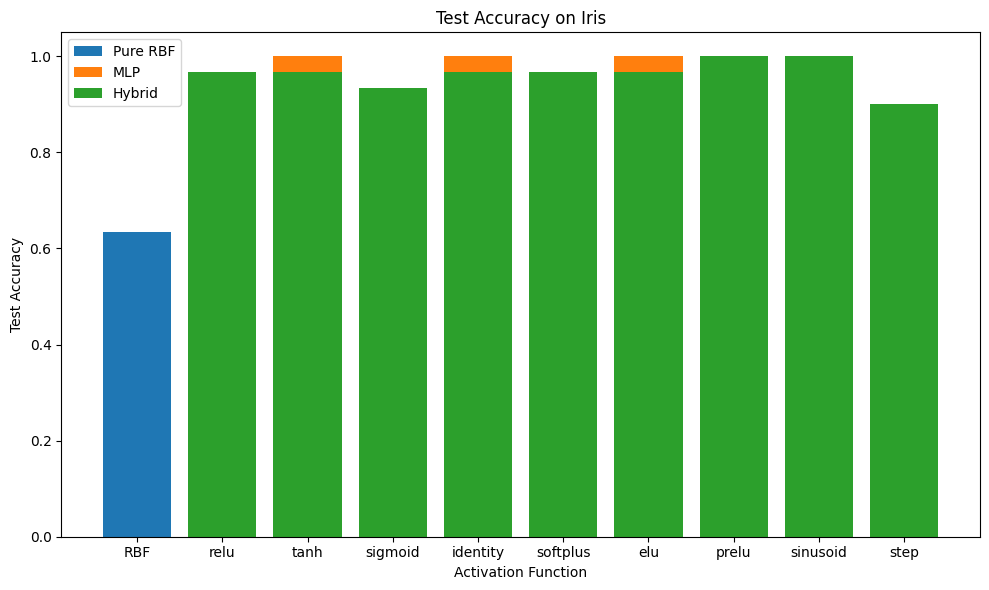

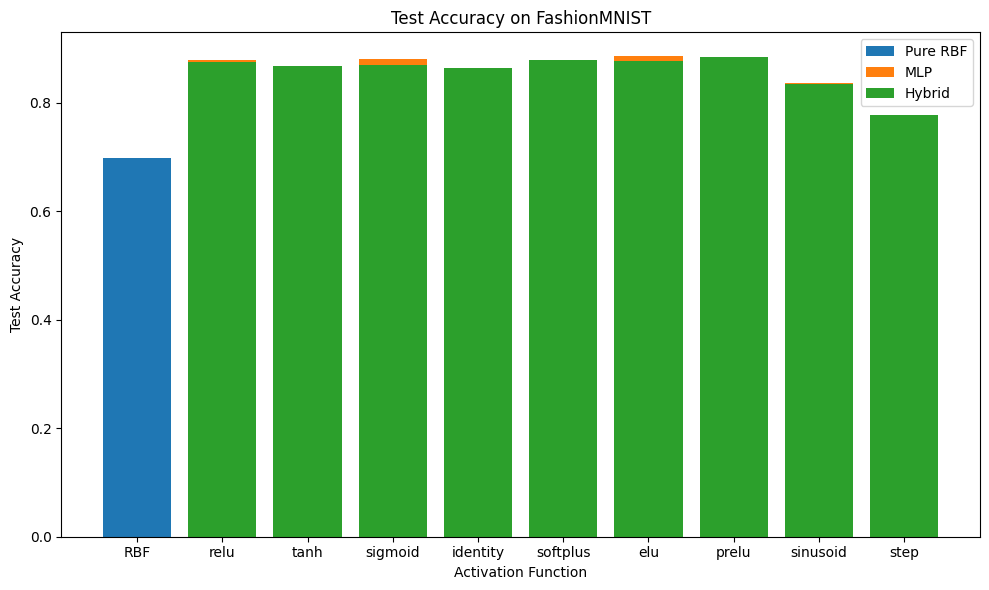

Iris Results:


,dataset,model_type,activation,test_loss,test_accuracy
0,Iris,Pure RBF,None,0.880204,0.633333
1,Iris,MLP,relu,0.197446,0.966667
2,Iris,Hybrid,relu,0.091069,0.966667
3,Iris,MLP,tanh,0.171197,1.000000
4,Iris,Hybrid,tanh,0.111265,0.966667
5,Iris,MLP,sigmoid,0.653393,0.833333
6,Iris,Hybrid,sigmoid,0.214842,0.933333
7,Iris,MLP,identity,0.122733,1.000000
8,Iris,Hybrid,identity,0.140098,0.966667
9,Iris,MLP,softplus,0.212663,0.966667



FashionMNIST Results:


,dataset,model_type,activation,test_loss,test_accuracy
0,FashionMNIST,Pure RBF,None,0.963775,0.6987
1,FashionMNIST,MLP,relu,0.403537,0.8791
2,FashionMNIST,Hybrid,relu,0.482265,0.8759
3,FashionMNIST,MLP,tanh,0.390557,0.8666
4,FashionMNIST,Hybrid,tanh,0.425478,0.8684
5,FashionMNIST,MLP,sigmoid,0.365633,0.8808
6,FashionMNIST,Hybrid,sigmoid,0.487439,0.8703
7,FashionMNIST,MLP,identity,0.454489,0.8395
8,FashionMNIST,Hybrid,identity,0.383098,0.8636
9,FashionMNIST,MLP,softplus,0.437334,0.8782


In [9]:
# Run experiments for both datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_iris = run_activation_experiments('iris', device=device)
results_fmnist = run_activation_experiments('fashion_mnist', device=device)

# Convert results to DataFrames
df_iris = pd.DataFrame([r for r in results_iris if r["dataset"]=="Iris"])
df_fmnist = pd.DataFrame([r for r in results_fmnist if r["dataset"]=="FashionMNIST"])

# Visualize: Bar charts for test accuracy for each model type and activation.
def plot_results(df, dataset_name, save_path):
    plt.figure(figsize=(10, 6))
    # Create a bar plot grouped by model_type and activation.
    for model_type in df["model_type"].unique():
        sub_df = df[df["model_type"]==model_type]
        # For pure RBF, activation is None; we label it accordingly.
        labels = sub_df["activation"].fillna("RBF")
        plt.bar(labels, sub_df["test_accuracy"], label=model_type)
    plt.title(f"Test Accuracy on {dataset_name}")
    plt.xlabel("Activation Function")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{dataset_name}_accuracy.png"))
    plt.show()
    
# Create a unique experiment folder to save results and visualizations.
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_folder = os.path.join("results", f"experiment_{timestamp}")
os.makedirs(experiment_folder, exist_ok=True)

# Plot and save results for Iris and FashionMNIST.
plot_results(df_iris, "Iris", experiment_folder)
plot_results(df_fmnist, "FashionMNIST", experiment_folder)

# Save the result tables as CSV files.
df_iris.to_csv(os.path.join(experiment_folder, "iris_results.csv"), index=False)
df_fmnist.to_csv(os.path.join(experiment_folder, "fashion_mnist_results.csv"), index=False)

# Display the tables.
print("Iris Results:")
display(df_iris)
print("\nFashionMNIST Results:")
display(df_fmnist)